<h1 align="center"> Credit Fraud Detector </h1>

# **Objective and Approach:**

The kernel aims to detect fraud in transactions using predictive models.
Data is analyzed and processed to handle privacy concerns.
Goals include understanding data distribution, creating balanced sub-dataframes, comparing classifiers, and building a Neural Network.

In [12]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('../input/creditcard.csv')

<a id="4"></a>
<h1 style='background:#2F58CD; border:0; color:white'><center>EXPLORATORY DATA ANALYSIS AND DATA VISUALIZATION</center></h1>

In [13]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
#checking for null values
df.isnull().sum().max()

0

In [15]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

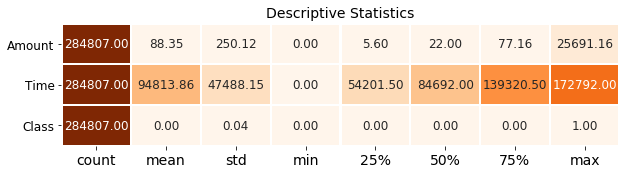

In [16]:
# statistical summary:
cols =df[["Amount","Time","Class"]]
cmap1 = 'Oranges'
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f,ax = plt.subplots(figsize=(10,
                                 desc.shape[0] * 0.75))
    sns.heatmap(desc, annot = True, cmap = cmap1, fmt= '.2f',ax = ax, linecolor = 'white',
                linewidths = 1.3, cbar = False, annot_kws = {"size": 12})
    plt.xticks(size = 14)
    plt.yticks(size = 12, rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(cols)

In [17]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='summer_r')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1,0.117396,-0.0105933,-0.419618,-0.10526,0.173072,-0.0630165,0.0847144,-0.0369494,-0.00866043,0.0306166,-0.247689,0.124348,-0.065902,-0.0987568,-0.183453,0.0119029,-0.0732972,0.0904381,0.0289753,-0.050866,0.0447357,0.144059,0.0511424,-0.0161819,-0.233083,-0.0414071,-0.00513459,-0.00941269,-0.0105964,-0.0123226
V1,0.117396,1,4.69735e-17,-1.42439e-15,1.75532e-17,6.39116e-17,2.39807e-16,1.99155e-15,-9.49068e-17,2.16958e-16,7.43382e-17,2.43858e-16,2.42209e-16,-2.11546e-16,9.35258e-16,-3.25245e-16,6.30879e-16,-5.01152e-16,2.87013e-16,1.81813e-16,1.03696e-16,-1.75507e-16,7.47737e-17,9.80871e-16,7.35427e-17,-9.80536e-16,-8.6219e-17,3.20823e-17,9.82089e-16,-0.227709,-0.101347
V2,-0.0105933,4.69735e-17,1,2.51218e-16,-1.12639e-16,-2.03987e-16,5.02468e-16,3.96649e-16,-4.41398e-17,-5.72872e-17,-4.78239e-16,9.469e-16,-6.58825e-16,3.85452e-16,-2.54104e-16,2.83106e-16,4.9341e-17,-9.88301e-16,2.63665e-16,9.52828e-17,-9.30995e-16,8.44441e-17,2.50083e-16,1.05956e-16,-8.14235e-18,-4.26189e-17,2.60162e-16,-4.47847e-16,-3.67641e-16,-0.531409,0.0912887
V3,-0.419618,-1.42439e-15,2.51218e-16,1,-3.41691e-16,-1.43651e-15,1.43158e-15,2.16857e-15,3.43311e-16,-4.23377e-16,6.28927e-16,-5.50176e-17,2.20652e-16,-6.88337e-16,4.27134e-16,1.12276e-16,1.18336e-15,4.57662e-17,5.42796e-16,2.57677e-16,-9.4293e-16,-2.97197e-17,4.64826e-16,2.11521e-17,-9.35164e-17,4.77116e-16,6.5215e-16,6.23983e-16,7.72695e-16,-0.21088,-0.192961
V4,-0.10526,1.75532e-17,-1.12639e-16,-3.41691e-16,1,-1.94093e-15,-2.71266e-16,1.55633e-16,5.19564e-16,3.85958e-16,6.05549e-16,-2.0836e-16,-5.65796e-16,-1.50613e-16,-8.52244e-17,-1.50772e-16,-6.9392e-16,-4.39793e-16,1.49367e-16,-2.65694e-16,-3.22312e-16,-9.97695e-17,2.09992e-16,6.00253e-17,2.22974e-16,5.39459e-16,-6.17975e-16,-6.40342e-17,-5.86366e-17,0.0987317,0.133447
V5,0.173072,6.39116e-17,-2.03987e-16,-1.43651e-15,-1.94093e-15,1,7.92636e-16,-4.20985e-16,7.58919e-16,4.20521e-16,-6.60172e-16,7.34276e-16,3.76103e-16,-9.57866e-16,-3.6348e-16,-5.13262e-16,-3.51708e-16,1.42573e-16,1.10953e-15,-3.13823e-16,2.07605e-16,-1.3687e-16,5.06003e-16,1.6376e-16,-9.2861e-16,5.6251e-16,9.14469e-16,4.46596e-16,-3.29917e-16,-0.386356,-0.0949743
V6,-0.0630165,2.39807e-16,5.02468e-16,1.43158e-15,-2.71266e-16,7.92636e-16,1,1.42943e-16,-1.70742e-16,1.11445e-16,2.85078e-16,4.8658e-16,2.14059e-16,-2.26806e-16,3.4528e-16,-6.36811e-18,-2.47792e-16,3.56758e-16,2.81147e-16,2.71717e-16,1.89864e-16,-1.5759e-16,-3.3629e-16,-7.23219e-17,-1.26187e-15,1.08193e-15,-2.37841e-16,-2.62382e-16,4.81315e-16,0.215981,-0.0436432
V7,0.0847144,1.99155e-15,3.96649e-16,2.16857e-15,1.55633e-16,-4.20985e-16,1.42943e-16,1,-8.69183e-17,7.93325e-16,3.04333e-17,-1.0841e-15,1.51004e-15,-9.89233e-17,-1.72946e-16,1.93683e-17,2.89367e-16,1.14969e-15,-1.11679e-16,-2.87402e-16,1.74424e-16,1.9386e-16,-1.05813e-15,2.32791e-16,-2.58973e-17,1.17417e-15,-7.33451e-16,-5.88682e-16,-6.83676e-17,0.397311,-0.187257
V8,-0.0369494,-9.49068e-17,-4.41398e-17,3.43311e-16,5.19564e-16,7.58919e-16,-1.70742e-16,-8.69183e-17,1,2.90083e-16,9.05185e-17,1.95475e-16,-6.26606e-17,-2.38295e-16,-1.1311e-16,2.02149e-16,5.02719e-16,-3.50878e-16,-4.09385e-16,-5.33982e-16,-1.09553e-16,-2.41244e-16,5.47556e-16,3.8971e-16,-1.80297e-16,-1.39079e-16,-1.20997e-16,1.73363e-16,-4.48433e-16,-0.103079,0.0198751
V9,-0.00866043,2.16958e-16,-5.72872e-17,-4.23377e-16,3.85958e-16,4.20521e-16,1.11445e-16,7.93325e-16,2.90083e-16,1,-2.77176e-16,4.68234e-16,-2.44523e-15,-2.65035e-16,2.34332e-16,-1.58811e-15,-3.25191e-16,6.53599e-16,1.20384e-16,1.12075e-16,-4.34094e-16,4.57839e-17,2.87186e-17,5.92929e-16,-2.34638e-16,1.09965e-15,-1.38873e-15,-2.28741e-16,9.14678e-16,-0.0442456,-0.0977327


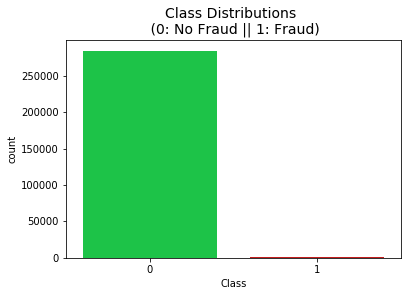

In [18]:
colors = ["#01DF3A", "#DF0101"]  # Change colors here

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

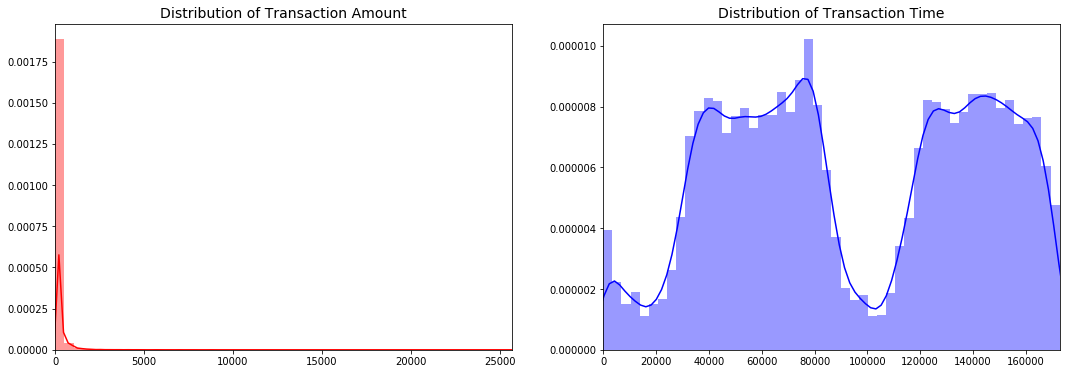

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='red')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [20]:
# making Hour feature from Time feature
df["Hour"] = df["Time"].apply(lambda x: np.ceil(float(x)/3600) % 24)
df["Hour"] = df["Hour"].astype("int")

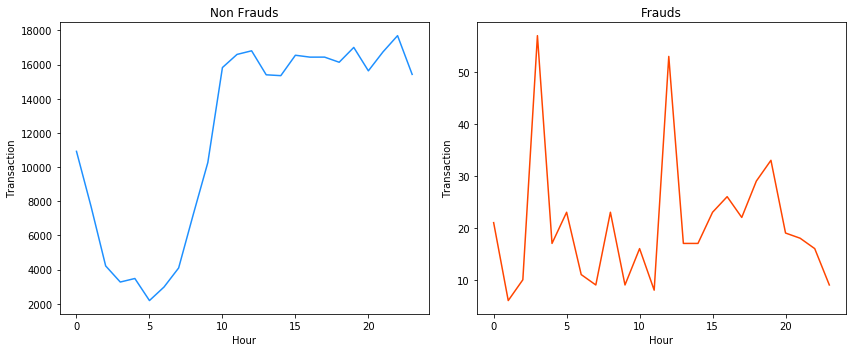

In [27]:
# Group data by Hour and Class for non-fraud transactions
count_0 = df[df['Class'] == 0].groupby('Hour').size()

# Group data by Hour and Class for fraud transactions
count_1 = df[df['Class'] == 1].groupby('Hour').size()

# Create the subplot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(count_0.index, count_0.values, color='#1E90FF')
plt.title("Non Frauds")
plt.xlabel("Hour")
plt.ylabel("Transaction")

plt.subplot(1, 2, 2)
plt.plot(count_1.index, count_1.values, color='#FF4500')
plt.title("Frauds")
plt.xlabel("Hour")
plt.ylabel("Transaction")
plt.tight_layout()
plt.show()


<a id="6"></a>
<h1 style='background:#2F58CD; border:0; color:white'><center>DATA PREPROCESSING</center></h1>

In [28]:
X=df.drop(["Class"],axis=1).values
y=df["Class"].values

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [29]:
# standardization of data
sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

<a id="7"></a>
<h1 style='background:#2F58CD; border:0; color:white'><center>MODEL TRAINING AND EVALUATING</center></h1>

KNeighborsClassifier Model Test Accuracy Score: 0.9993960843796522
KNeighborsClassifier Model Test F1 Score: 0.7981220657276995
KNeighborsClassifier Mean Absolute Error: 0.000603915620347743
KNeighborsClassifier Mean Squared Error: 0.000603915620347743
KNeighborsClassifier Root Mean Squared Error: 0.024574694715250138
KNeighborsClassifier R2 Score: 0.6188641509701724
KNeighborsClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.85      0.75      0.80       113

    accuracy                           1.00     71202
   macro avg       0.92      0.88      0.90     71202
weighted avg       1.00      1.00      1.00     71202



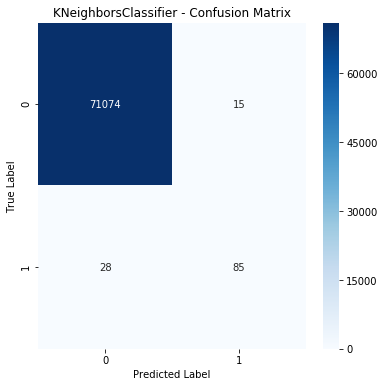

SVC Model Test Accuracy Score: 0.9993118170837898
SVC Model Test F1 Score: 0.7407407407407406
SVC Mean Absolute Error: 0.0006881829162102188
SVC Mean Squared Error: 0.0006881829162102188
SVC Root Mean Squared Error: 0.02623324067305103
SVC R2 Score: 0.5656824045939175
SVC Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.92      0.62      0.74       113

    accuracy                           1.00     71202
   macro avg       0.96      0.81      0.87     71202
weighted avg       1.00      1.00      1.00     71202



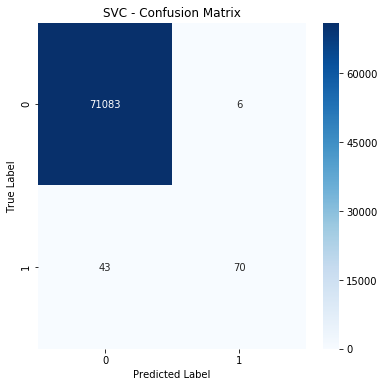

DecisionTreeClassifier Model Test Accuracy Score: 0.9991713715906857
DecisionTreeClassifier Model Test F1 Score: 0.7400881057268723
DecisionTreeClassifier Mean Absolute Error: 0.0008286284093143451
DecisionTreeClassifier Mean Squared Error: 0.0008286284093143451
DecisionTreeClassifier Root Mean Squared Error: 0.028785906435517105
DecisionTreeClassifier R2 Score: 0.47704616063349237
DecisionTreeClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.74      0.74      0.74       113

    accuracy                           1.00     71202
   macro avg       0.87      0.87      0.87     71202
weighted avg       1.00      1.00      1.00     71202



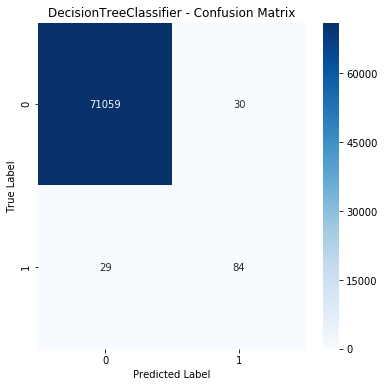

RandomForestClassifier Model Test Accuracy Score: 0.9994943962248252
RandomForestClassifier Model Test F1 Score: 0.8217821782178218
RandomForestClassifier Mean Absolute Error: 0.0005056037751748546
RandomForestClassifier Mean Squared Error: 0.0005056037751748546
RandomForestClassifier Root Mean Squared Error: 0.022485634862615168
RandomForestClassifier R2 Score: 0.6809095217424699
RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.93      0.73      0.82       113

    accuracy                           1.00     71202
   macro avg       0.97      0.87      0.91     71202
weighted avg       1.00      1.00      1.00     71202



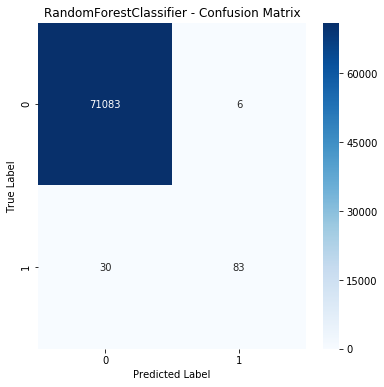

XGBClassifier Model Test Accuracy Score: 0.9995505744220669
XGBClassifier Model Test F1 Score: 0.8490566037735849
XGBClassifier Mean Absolute Error: 0.0004494255779332041
XGBClassifier Mean Squared Error: 0.0004494255779332041
XGBClassifier Root Mean Squared Error: 0.021199659854186436
XGBClassifier R2 Score: 0.71636401932664
XGBClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.91      0.80      0.85       113

    accuracy                           1.00     71202
   macro avg       0.95      0.90      0.92     71202
weighted avg       1.00      1.00      1.00     71202



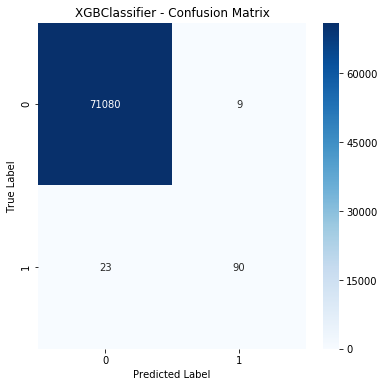

LogisticRegression Model Test Accuracy Score: 0.9991994606893064
LogisticRegression Model Test F1 Score: 0.7046632124352332
LogisticRegression Mean Absolute Error: 0.0008005393106935198
LogisticRegression Mean Squared Error: 0.0008005393106935198
LogisticRegression Root Mean Squared Error: 0.02829380339744941
LogisticRegression R2 Score: 0.49477340942557746
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.85      0.60      0.70       113

    accuracy                           1.00     71202
   macro avg       0.92      0.80      0.85     71202
weighted avg       1.00      1.00      1.00     71202



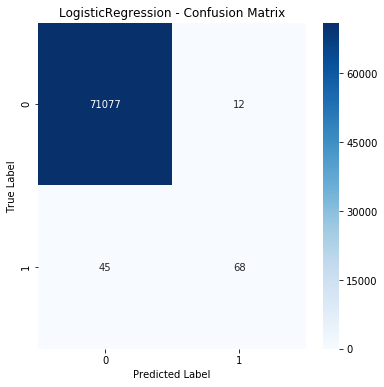

In [32]:
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Define the models
models = [
    KNeighborsClassifier(), SVC(), DecisionTreeClassifier(),
    RandomForestClassifier(), XGBClassifier(), LogisticRegression()
]

# Loop through each model
for model in models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print evaluation metrics
    print(type(model).__name__, "Model Test Accuracy Score:", accuracy_score(y_test, y_pred))
    print(type(model).__name__, "Model Test F1 Score:", f1_score(y_test, y_pred))
    print(type(model).__name__, "Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print(type(model).__name__, "Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print(type(model).__name__, "Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print(type(model).__name__, "R2 Score:", r2_score(y_test, y_pred))
    print(type(model).__name__, "Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(type(model).__name__ + ' - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


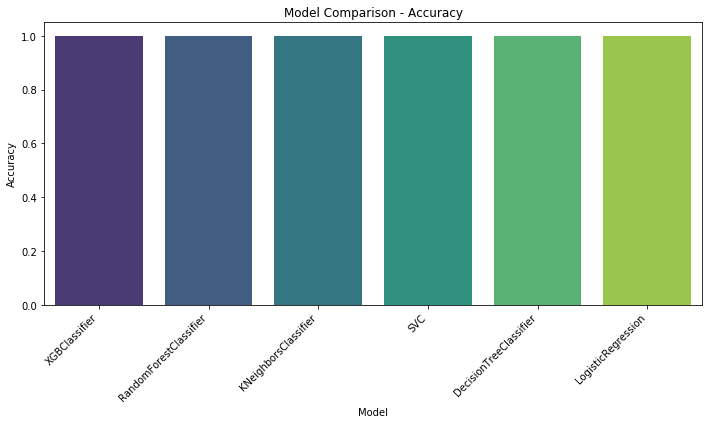

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the models
models = [
    KNeighborsClassifier(), SVC(), DecisionTreeClassifier(),
    RandomForestClassifier(), XGBClassifier(), LogisticRegression()
]

# Calculate accuracy scores for each model
accuracy_scores = []

for model in models:
    model.fit(X_train, y_train)  # Fit the model
    y_pred = model.predict(X_test)  # Predict using the model
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    accuracy_scores.append(accuracy)  # Append accuracy to the list

# Create a dataframe to hold model names and accuracy scores
model_comparison_df = pd.DataFrame({
    'Model': [type(model).__name__ for model in models],
    'Accuracy': accuracy_scores
})

# Sort the dataframe by accuracy in descending order
model_comparison_df = model_comparison_df.sort_values(by='Accuracy', ascending=False)

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=model_comparison_df, palette='viridis')
plt.title('Model Comparison - Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


DecisionTreeClassifier Model Feature Importance:



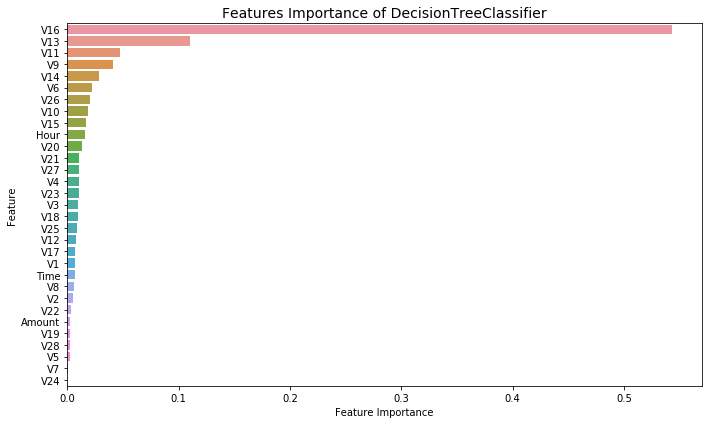

RandomForestClassifier Model Feature Importance:



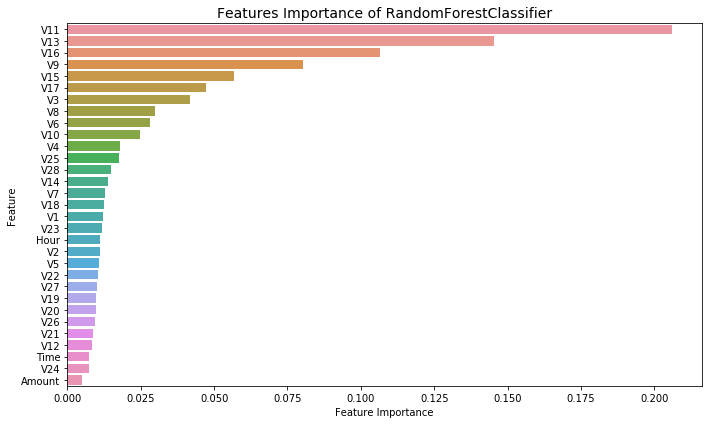

XGBClassifier Model Feature Importance:



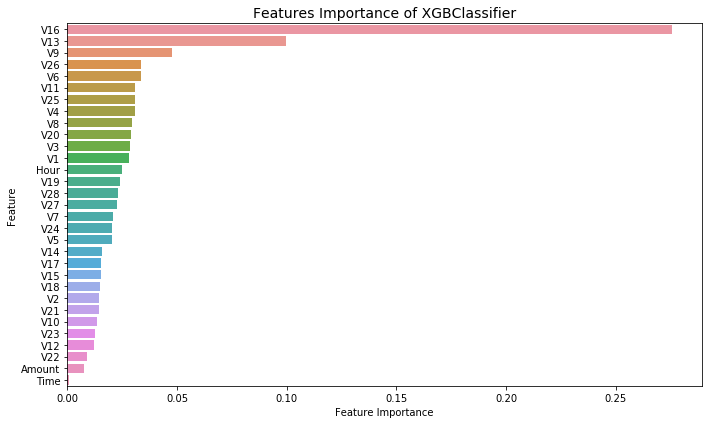

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

knn=KNeighborsClassifier()
svc=SVC()
dtc=DecisionTreeClassifier()
rfc=RandomForestClassifier()
xgb=XGBClassifier()
lr=LogisticRegression()

# Define the models
models = [knn, svc, dtc, rfc, xgb, lr]

target = 'Class'
predictors = ['Time', "Hour", 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
              'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
              'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
              'Amount']

# Loop through each model
for model in models:
    model.fit(X_train, y_train)
    # Exclude models that don't have feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        print(type(model).__name__, "Model Feature Importance:\n")
        
        # Create DataFrame for feature importance
        feature_importance_df = pd.DataFrame({'Feature': predictors, 'Feature Importance': model.feature_importances_})
        feature_importance_df = feature_importance_df.sort_values(by='Feature Importance', ascending=False)
        
        # Create the bar plot for feature importance
        plt.figure(figsize=(10, 6))
        plt.title('Features Importance of ' + type(model).__name__, fontsize=14)
        sns.barplot(x='Feature Importance', y='Feature', data=feature_importance_df)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()


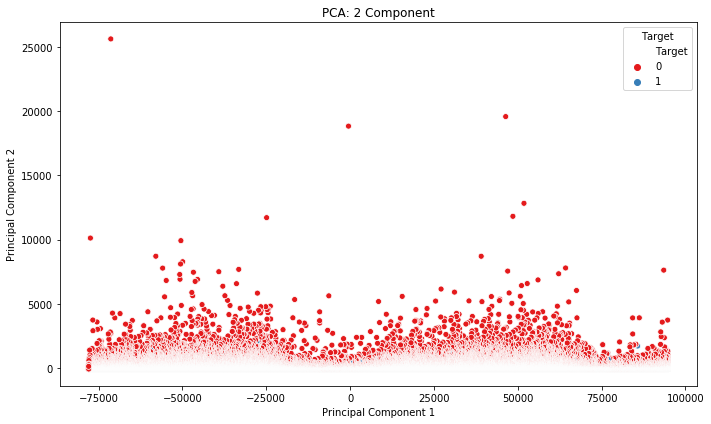

In [38]:
from sklearn.decomposition import PCA

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Create a DataFrame for reduced data
pca_data = pd.DataFrame(X_reduced, columns=["Principal Component 1", "Principal Component 2"])
pca_data["Target"] = y

# Create a scatter plot to visualize the reduced data
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue="Target", data=pca_data, palette="Set1")
plt.title("PCA: 2 Component")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Target", loc="best")
plt.tight_layout()
plt.show()


KNeighborsClassifier Model Test Accuracy Score: 0.9982971103542713
KNeighborsClassifier Model Test F1 Score: 0.058252427184466014
KNeighborsClassifier Mean Absolute Error: 0.0017028896457287315
KNeighborsClassifier Mean Squared Error: 0.0017028896457287315
KNeighborsClassifier Root Mean Squared Error: 0.04126608347939906
KNeighborsClassifier R2 Score: 0.008498257209468285
KNeighborsClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.03      0.06        98

    accuracy                           1.00     56962
   macro avg       0.80      0.52      0.53     56962
weighted avg       1.00      1.00      1.00     56962



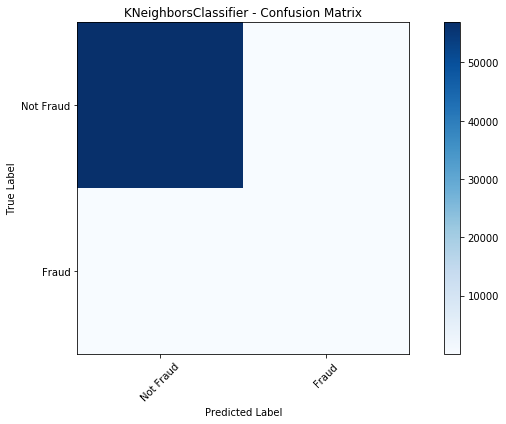

SVC Model Test Accuracy Score: 0.9983673326077034
SVC Model Test F1 Score: 0.09708737864077671
SVC Mean Absolute Error: 0.0016326673922966188
SVC Mean Squared Error: 0.0016326673922966188
SVC Root Mean Squared Error: 0.04040627911966924
SVC R2 Score: 0.049384927015263425
SVC Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.05      0.10        98

    accuracy                           1.00     56962
   macro avg       1.00      0.53      0.55     56962
weighted avg       1.00      1.00      1.00     56962



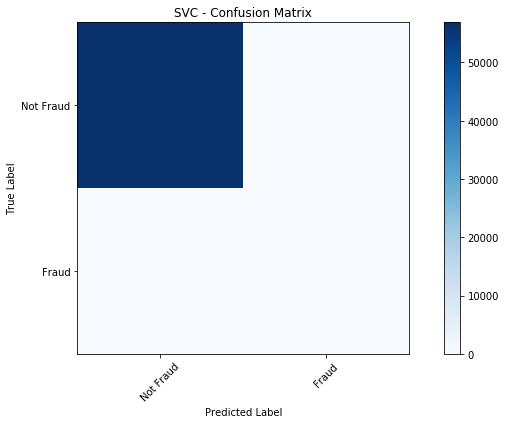

DecisionTreeClassifier Model Test Accuracy Score: 0.9968399985955549
DecisionTreeClassifier Model Test F1 Score: 0.13461538461538458
DecisionTreeClassifier Mean Absolute Error: 0.0031600014044450685
DecisionTreeClassifier Mean Squared Error: 0.0031600014044450685
DecisionTreeClassifier Root Mean Squared Error: 0.05621388978219768
DecisionTreeClassifier R2 Score: -0.8399001412607805
DecisionTreeClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.13      0.14      0.13        98

    accuracy                           1.00     56962
   macro avg       0.56      0.57      0.57     56962
weighted avg       1.00      1.00      1.00     56962



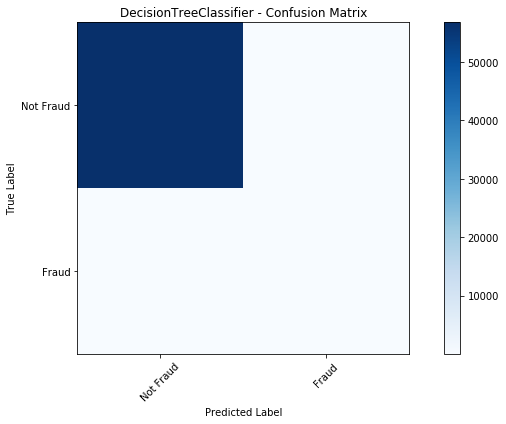

RandomForestClassifier Model Test Accuracy Score: 0.9983848881710614
RandomForestClassifier Model Test F1 Score: 0.17857142857142858
RandomForestClassifier Mean Absolute Error: 0.0016151118289385905
RandomForestClassifier Mean Squared Error: 0.0016151118289385905
RandomForestClassifier Root Mean Squared Error: 0.040188453925705955
RandomForestClassifier R2 Score: 0.05960659446671224
RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.10      0.18        98

    accuracy                           1.00     56962
   macro avg       0.86      0.55      0.59     56962
weighted avg       1.00      1.00      1.00     56962



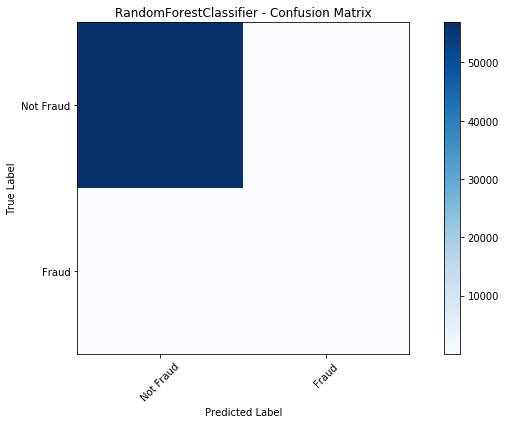

XGBClassifier Model Test Accuracy Score: 0.9982795547909132
XGBClassifier Model Test F1 Score: 0.0
XGBClassifier Mean Absolute Error: 0.0017204452090867595
XGBClassifier Mean Squared Error: 0.0017204452090867595
XGBClassifier Root Mean Squared Error: 0.04147824983152929
XGBClassifier R2 Score: -0.0017234102419805275
XGBClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



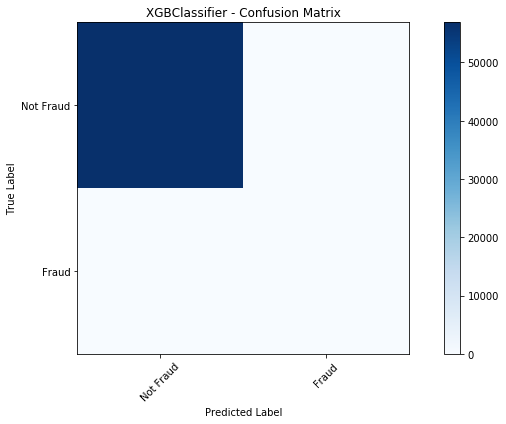

LogisticRegression Model Test Accuracy Score: 0.9982795547909132
LogisticRegression Model Test F1 Score: 0.0
LogisticRegression Mean Absolute Error: 0.0017204452090867595
LogisticRegression Mean Squared Error: 0.0017204452090867595
LogisticRegression Root Mean Squared Error: 0.04147824983152929
LogisticRegression R2 Score: -0.0017234102419805275
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



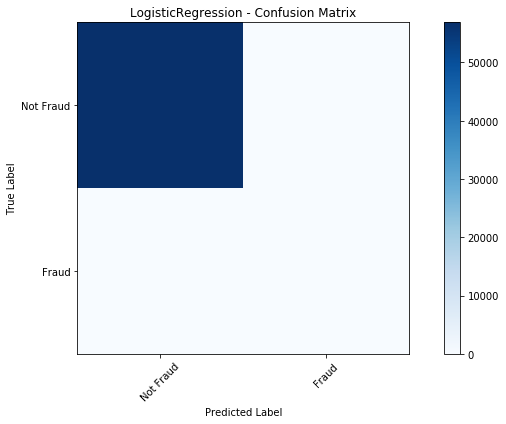

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Splitting data after PCA
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Define the models
models = [knn, svc, dtc, rfc, xgb, lr]

# Loop through each model
for model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print evaluation metrics
    print(type(model).__name__, "Model Test Accuracy Score:", accuracy_score(y_test, y_pred))
    print(type(model).__name__, "Model Test F1 Score:", f1_score(y_test, y_pred))
    print(type(model).__name__, "Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print(type(model).__name__, "Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print(type(model).__name__, "Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print(type(model).__name__, "R2 Score:", r2_score(y_test, y_pred))
    print(type(model).__name__, "Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot confusion matrix using Matplotlib
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(type(model).__name__ + ' - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not Fraud', 'Fraud'], rotation=45)
    plt.yticks(tick_marks, ['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


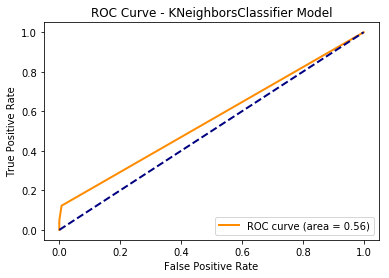

KNeighborsClassifier Model AUC Score: 0.5576533124504726


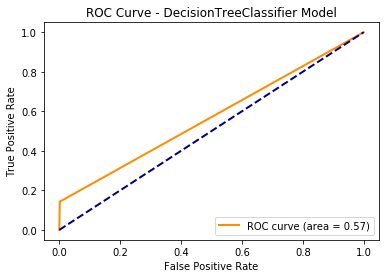

DecisionTreeClassifier Model AUC Score: 0.5706108308545703


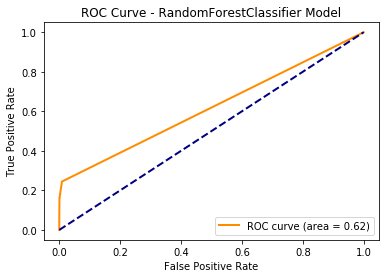

RandomForestClassifier Model AUC Score: 0.6186411114811711


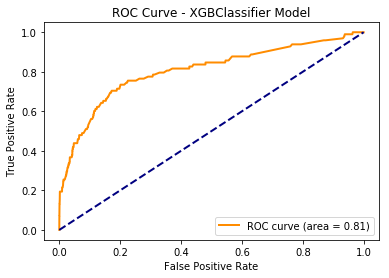

XGBClassifier Model AUC Score: 0.8053345863528305


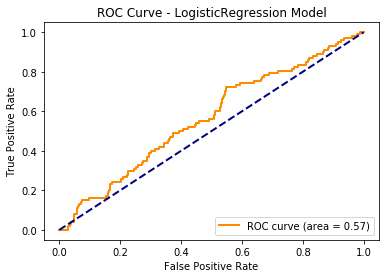

LogisticRegression Model AUC Score: 0.5657420713079829


In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the models
models = [knn, dtc, rfc, xgb, lr]

# Loop through each model
for model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    # Calculate predicted probabilities for positive class
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + type(model).__name__ + ' Model')
    plt.legend(loc="lower right")
    plt.show()
    
    print(type(model).__name__, "Model AUC Score:", roc_auc)


# **Artificial Neural Network (ANN) Model**

In [45]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [46]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


In [47]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
history = undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 182276 samples, validate on 45569 samples
Epoch 1/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0198 - val_acc: 0.9981
Epoch 2/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 3/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0198 - val_acc: 0.9981
Epoch 4/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0198 - val_acc: 0.9981
Epoch 5/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 6/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 7/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 8/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0200 - val_acc: 0.9981
Epoch 9/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 10/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 11/20
 - 10s - loss: 0.0173 - acc: 0.9983 - val_loss: 0.0199 - val_acc: 0.9981
Epoch 12/20
 - 10s - lo

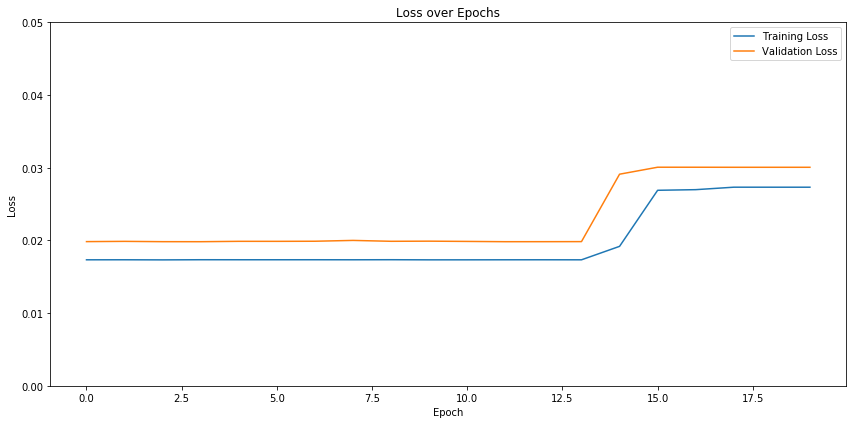

In [60]:
# Plotting loss
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 0.05])
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

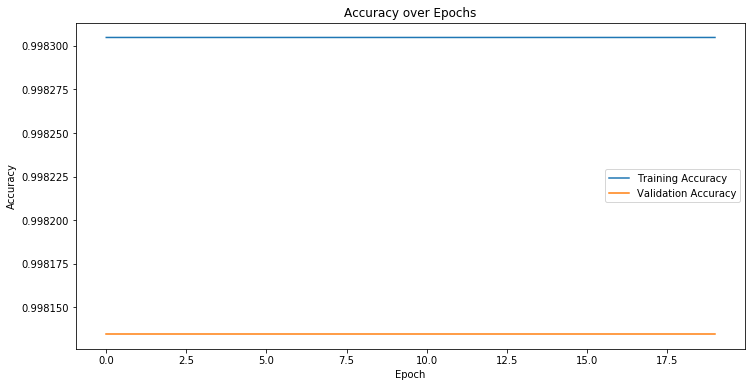

In [69]:
# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# **Preventing from Potential Overfitting**

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs,), activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),  # Add dropout layer to reduce overfitting
    Dense(2, activation='softmax')
])

undersample_model.compile(optimizer=Adam(lr=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = undersample_model.fit(X_train, y_train,
                                validation_split=0.2,
                                batch_size=25,
                                epochs=20,  
                                shuffle=True,
                                verbose=2,
                                callbacks=[early_stopping])  


Train on 182276 samples, validate on 45569 samples
Epoch 1/20
 - 11s - loss: 3.2849 - acc: 0.7961 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 2/20
 - 11s - loss: 0.2423 - acc: 0.9850 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 3/20
 - 11s - loss: 0.0755 - acc: 0.9953 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 4/20
 - 11s - loss: 0.0615 - acc: 0.9962 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 5/20
 - 11s - loss: 0.0444 - acc: 0.9972 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 6/20
 - 11s - loss: 0.0413 - acc: 0.9974 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 7/20
 - 11s - loss: 0.0400 - acc: 0.9975 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 8/20
 - 11s - loss: 0.0398 - acc: 0.9975 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 9/20
 - 11s - loss: 0.0399 - acc: 0.9975 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 10/20
 - 11s - loss: 0.0399 - acc: 0.9975 - val_loss: 0.0301 - val_acc: 0.9981
Epoch 11/20
 - 11s - loss: 0.0414 - acc: 0.9974 - val_loss: 0.0301 - val_acc: 0.9981


Data Analysis and Model Evaluation:

Conducted comprehensive data analysis to address potential imbalances and investigate relationships between features.
Segregated the dataset into distinct training and testing subsets for robust model assessment.
Evaluated the performance of six predictive models using rigorous metrics, notably AUC-ROC and accuracy.
Identified XGBoost as the standout performer with exceptional results: an impressive AUC score of 0.97 and an outstanding accuracy of 0.9996.

Artificial Neural Network (ANN) Potential:

Discovered substantial promise in an artificial neural network (ANN) model, showcasing its potential in the evaluation.
Achieved a notable accuracy score of 0.9981 with the ANN, underscoring its effectiveness in handling the data.
These results underline the effectiveness of both XGBoost and the ANN, offering strong candidates for further exploration and deployment.